# Unsupervised learning
finding patterns in data

## Clustering with Kmeans

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


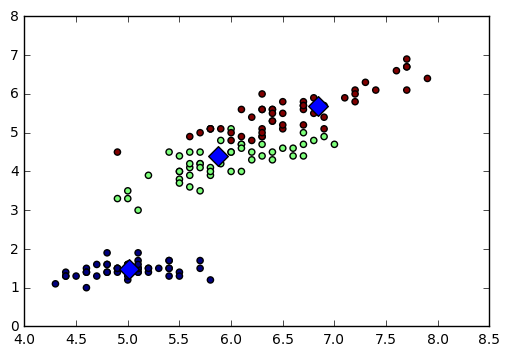

In [51]:
from sklearn.cluster import KMeans
from sklearn import datasets
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

iris = datasets.load_iris()

X = iris.data

y = iris.target

print(iris.feature_names)

xs = X[:, 0]
ys = X[:, 2]

plt.scatter(xs, ys, c=y)


model = KMeans(n_clusters=3) # 3 species of iris


model.fit(np.c_[xs, ys])


centroids = model.cluster_centers_
centroids_x = centroids[:,0]
centroids_y = centroids[:,1]

plt.scatter(centroids_x, centroids_y, s=100, marker='D')
plt.show()



### Evaluating a clustering
- Measuring quality of clustering
- A good clustering has tight clusters
- Minizing the distance from each sampel to its centroid, by minimizing **model.inertia_**
- Choose an elbow in the intertia plot (when it begins to decrease more slowly)

In [52]:
species_df = pd.DataFrame(iris.target)
for i in range(3):
    species_df.replace(i, iris.target_names[i], inplace=True)
species = species_df.values.flatten()


df = pd.DataFrame({'labels' : model.fit_predict(X), 'species' : species})

### Build A cross tab

In [54]:
ct = pd.crosstab(df['labels'], df['species'])
print(ct)

species  setosa  versicolor  virginica
labels                                
0            50           0          0
1             0          48         14
2             0           2         36


### Finding the best clusters count using inertia

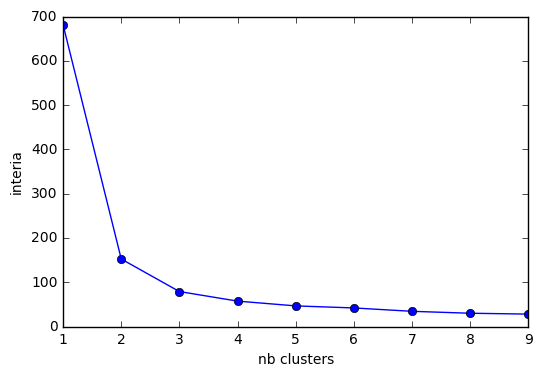

In [55]:
inerias = []
clusters = []
for k in range(1, 10):
    clusters.append(k)
    model = KMeans(n_clusters=k)
    model.fit(X)
    inerias.append(model.inertia_)
    
plt.plot(clusters, inerias, marker="o")
plt.xlabel('nb clusters')
plt.ylabel('interia')
plt.xticks(clusters)
plt.show()

### Preprocessing: Transforming features for better clusterings

In [80]:
wines = datasets.load_wine()
samples = wines.data
varieties = np.array(wines.target).astype(str)

for i in range(3):
    varieties[varieties == str(i)] = wines.target_names[i]

model = KMeans(n_clusters=3)
labels = model.fit_predict(samples)

df = pd.DataFrame({'labels' : labels, 'varieties' : varieties})

ct = pd.crosstab(df['labels'], df['varieties'])
print(ct)

varieties  class_0  class_1  class_2
labels                              
0               13       20       29
1               46        1        0
2                0       50       19


#### Features variances
- The wines features have very different variances
- Variance of a feature measures spread of its values
- In Kmeans: feature variance = feature influence
- Use StandarScaler to transform each feature to mean 0 and variance 1

In [84]:
df = pd.DataFrame(data=wines.data, columns=wines.feature_names)
df.var()

alcohol                             0.659062
malic_acid                          1.248015
ash                                 0.075265
alcalinity_of_ash                  11.152686
magnesium                         203.989335
total_phenols                       0.391690
flavanoids                          0.997719
nonflavanoid_phenols                0.015489
proanthocyanins                     0.327595
color_intensity                     5.374449
hue                                 0.052245
od280/od315_of_diluted_wines        0.504086
proline                         99166.717355
dtype: float64

In [89]:
from sklearn.preprocessing import StandardScaler 
scaler = StandardScaler()

scaler.fit(samples)

samples_scaled = scaler.transform(samples)

df = pd.DataFrame(data=samples_scaled, columns=wines.feature_names)
df.var()

alcohol                         1.00565
malic_acid                      1.00565
ash                             1.00565
alcalinity_of_ash               1.00565
magnesium                       1.00565
total_phenols                   1.00565
flavanoids                      1.00565
nonflavanoid_phenols            1.00565
proanthocyanins                 1.00565
color_intensity                 1.00565
hue                             1.00565
od280/od315_of_diluted_wines    1.00565
proline                         1.00565
dtype: float64

In [95]:
#combining everything in a machine learning pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline

scaler = StandardScaler()
model = KMeans(n_clusters=3)

steps = [('scaler', scaler), ('clustering', model)]

pipeline = Pipeline(steps)

pipeline.fit(samples)

labels = pipeline.predict(samples)

# we can now see the difference after scaling our features !!

df = pd.DataFrame({'labels' : labels, 'varieties' : varieties})

ct = pd.crosstab(df['labels'], df['varieties'])
print(ct)

varieties  class_0  class_1  class_2
labels                              
0                0        3       48
1               59        3        0
2                0       65        0


## Visualization with hierarchical clustering and t-SNE


### Hierarchical clustering with SciPy

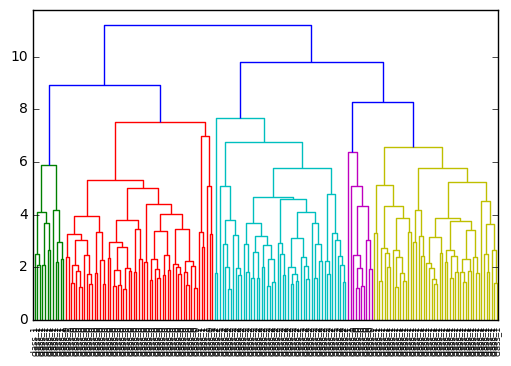

In [132]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram

mergings = linkage(samples_scaled, method='complete')

#a tree diagram, especially one showing taxonomic relationships.
dendrogram(mergings, labels=varieties, leaf_rotation=90, leaf_font_size=6)
plt.show()

In [153]:
#Extracting cluster lables using fcluster depdending on the height of when the merge 
#did happen

from scipy.cluster.hierarchy import fcluster
# 400 is the height
labels = fcluster(mergings, 9, criterion="distance")

df = pd.DataFrame({'labels' : labels, 'varieties' : varieties})

ct = pd.crosstab(df['labels'], df['varieties'])
print(ct)

varieties  class_0  class_1  class_2
labels                              
1               51       18        0
2                0        3       48
3                8       50        0


### t-SNE for 2-dimensional maps
t-distributed stochastic neighbor embedding
- Maps samples to 2D spaces (or 3D)
- Map apprroximately preserves nearness of samples
- Great for inspecting datasets

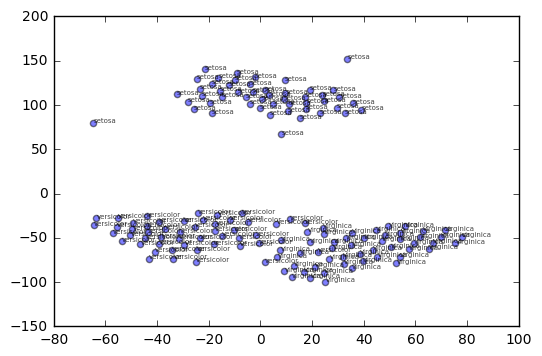

In [182]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import normalize
samples = iris.data

#learning is bad when we have everything bunched together!!
#try values between 50 and 200
model = TSNE(learning_rate=500)

#when method that fits and tranforms the data!!! ==> we can't extend the map
#include new samples

transformed = model.fit_transform(normalize(samples))

xs = transformed[:, 0]
ys = transformed[:, 1]

varieties = np.array(iris.target).astype(str)

for i in range(3):
    varieties[varieties == str(i)] = iris.target_names[i]


plt.scatter(xs, ys, alpha=0.5)
    
# Annotate the points
for x, y, variety in zip(xs, ys, varieties):
    plt.annotate(variety, (x, y), fontsize=5, alpha=0.75)
plt.show()

## Visualizing the PCA transformation


### Dimension reduction
- Leanrs the principal components of the data
- Remove less-informative "noise" features
- Rotates data samples to be aligned with axes
- Shifts data samples so they have mean 0
- No information is lot
- Steps :
    - First step decorrelation (PCA features are not correlated)
    - Reduces dimension

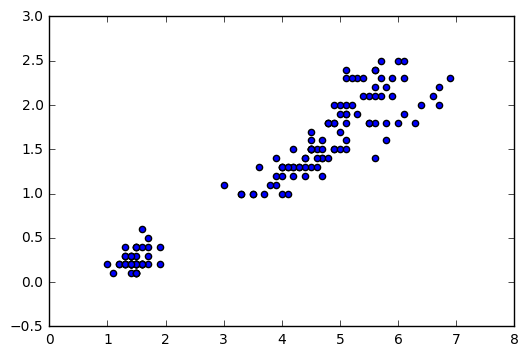

corr = 0.962757097051


In [200]:
#check correlation between features

from scipy.stats import pearsonr

xs = samples[:,2]
ys = samples[:,3]

plt.scatter(xs, ys)
plt.show()


correlation, pvalue = pearsonr(xs, ys)
print("corr =", correlation)

shape after transormation (210, 2)
corr = 0.86041
[ 3.25860476  5.62853333] [ 0.63910027  0.76912343]


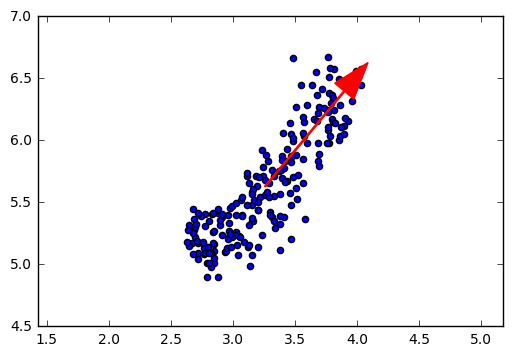

In [273]:
df = pd.read_csv('data/grains.csv', header=None)
grains = df.values


from sklearn.decomposition import PCA

model = PCA()

model.fit(grains)

pca_features = model.transform(grains)

print('shape after transormation', pca_features.shape) #same shape

xs = grains[:,0]
ys = grains[:,1]

plt.scatter(xs, ys)

correlation, pvalue = pearsonr(xs, ys)
# now correlation has to be 0
print("corr =", round(correlation, 5))

mean = model.mean_
first_pc = model.components_[0,:]

print(mean, first_pc)

#plots the direction in which data varies the most!
# Plot first_pc as an arrow, starting at mean
plt.arrow(mean[0], mean[1], first_pc[0], first_pc[1], color='red', width=0.01)

# Keep axes on same scale
plt.axis('equal')
plt.show()

### Intrinsic dimension
- Intrinsic dimension = number of features needed to approximate the dataset
- What is the most compact representation of the samples
-  That the intrinsic dimension is the **number of PCA features with significant variance** !!!

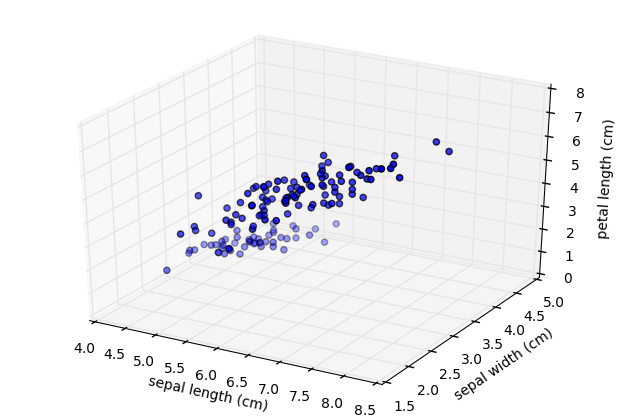

In [275]:
samples = iris.data
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = Axes3D(fig)

#we can see that they all lie very close to a flat, 2d sheet
ax.scatter(samples[:, 0], samples[:, 1], samples[:, 2])
ax.set_xlabel(iris.feature_names[0])
ax.set_ylabel(iris.feature_names[1])
ax.set_zlabel(iris.feature_names[2])
plt.show()

### Plotting the variances of PCA features
which helps us answer the following question what is its intrinsic dimension?

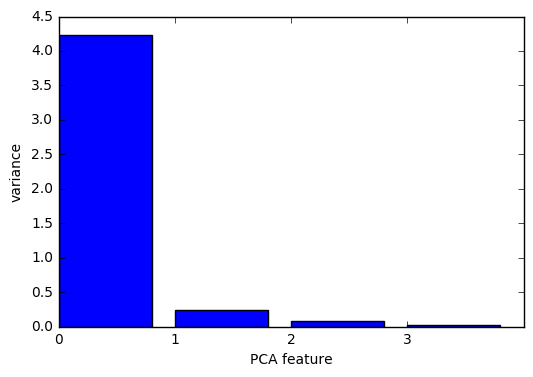

In [279]:
model.fit(samples)
features = range(model.n_components_)
plt.bar(features, model.explained_variance_)
plt.xticks(features)
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.show()

#I looks like PCA features 0 and 1 have have significant variances!
#Recall that the intrinsic dimension is the number of PCA features with significant variance
#So we choose 2

### Dimension reduction with PCA
- Represents same data using less features
- Important part of machine learning piplines
- PCA discards low variance PCA features
- Assumes that the high variance features are informative

(150, 2)


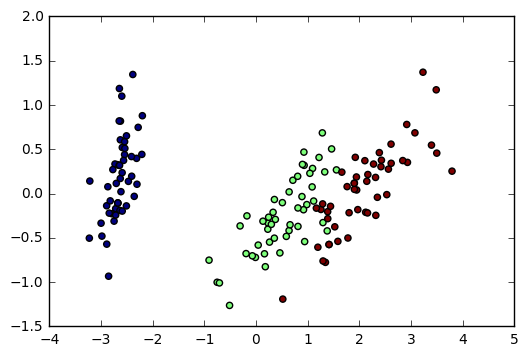

In [287]:
pca = PCA(n_components=2)
pca.fit(samples)
transformed = pca.transform(samples)

print(transformed.shape) #we only kept two features!!

xs = transformed[:,0]
ys = transformed[:,1]

plt.scatter(xs, ys, c=iris.target)
plt.show()

In [294]:
from sklearn.decomposition import TruncatedSVD 
from sklearn.feature_extraction.text import TfidfVectorizer

documents = ['cats say meow', 'dogs say woof', 'dogs chase cats']

# Create a TfidfVectorizer: tfidf
tfidf = TfidfVectorizer() 

# Apply fit_transform to document: csr_mat
csr_mat = tfidf.fit_transform(documents)

# Get the words: words
words = tfidf.get_feature_names()

# Print words
print(words)

['cats', 'chase', 'dogs', 'meow', 'say', 'woof']


## Clustering Wikipeadia artciles
Data set available here https://blog.lateral.io/2015/06/the-unknown-perils-of-mining-wikipedia/

In [146]:
#Clustering wiki articles
import pandas as pd

df = pd.read_csv("data/wikipedia_articles_to_cluster.csv",  encoding = "ISO-8859-1")
titles = df.title


df.head()

,title,article_text
0,HTTP 404,HTTP 404 The 404 or Not Found error message ...
1,Alexa Internet,"Alexa Internet Alexa Internet, Inc. is a Cal..."
2,Internet Explorer,Internet Explorer 10 Internet Explorer 10 (I...
3,HTTP cookie,"HTTP cookie A cookie, also known as an HTTP ..."
4,Google Search,Google Search Appliance The Google Search Ap...


In [147]:
from sklearn.decomposition import TruncatedSVD 
from sklearn.feature_extraction.text import TfidfVectorizer

# Create a TfidfVectorizer: tfidf
tfidf = TfidfVectorizer() 

# Apply fit_transform to document: csr_mat
articles = tfidf.fit_transform(df.article_text.values)

In [32]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans

svd = TruncatedSVD(n_components=50)
kmeans = KMeans(n_clusters=6)

pipeline = make_pipeline(svd, kmeans)

pipeline.fit(articles)

labels = pipeline.predict(articles)

df = pd.DataFrame({'labels': labels, 'article': df.title})

print(df.sort_values('labels'))

                                          article  labels
29                               Jennifer Aniston       0
31                              Cristiano Ronaldo       1
32                                   Arsenal F.C.       1
33                                 Radamel Falcao       1
34                             Zlatan Ibrahimovi?       1
35                Colombia national football team       1
36              2014 FIFA World Cup qualification       1
37                                       Football       1
38                                         Neymar       1
39                                  Franck Ribéry       1
51                                     Nate Ruess       1
52                                     The Wanted       1
54                                 Arctic Monkeys       1
55                                  Black Sabbath       1
56                                       Skrillex       1
57                          Red Hot Chili Peppers       1
30            

## Non-negative matrix factorization (NMF)
- In contract to PCA, NMF models are interpretable
- Needs all features to be non negative > 0
- NMF expresses documents as combinations of topics (or "themes")
- NMF expresses images as combinations of patterns
- NMF has components learned from samples just like PCA
- NMF feature values are non-negative as well
- A sample can be reconstructed by multiplying components
by feature values and add up.

In [24]:
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import datasets

iris = datasets.load_iris()
samples = iris.data

model = NMF(n_components=2)

model.fit(samples)

nmf_features = model.transform(samples)

print(model.components_)

[[ 5.7528193   2.31736196  5.26603216  1.88949154]
 [ 3.38130621  2.44971744  0.63732832  0.        ]]


### A sample can be reconstructed by multiplying components by feature values and add up.


In [26]:
#samples ~= nmf_features.dot(model.components_)

print(samples[0, :])
print(nmf_features[0, :].dot(model.components_))

[ 5.1  3.5  1.4  0.2]
[ 5.09980563  3.49980804  1.40176904  0.19905119]


In [64]:
#Applying NMF to wikipedia articles
model = NMF(n_components=6)
model.fit(articles)
nmf_features = model.transform(articles)

df = pd.DataFrame(nmf_features, index=titles)
#We Notice that for both actors, the NMF feature 1 has by far the highest value. 
#This means that both articles are reconstructed using mainly the 2d NMF component.
# NMF components represent topics (for instance, acting!)

print(df.loc['Anne Hathaway'].nlargest())
print(df.loc['Denzel Washington'].nlargest())

1    0.462717
3    0.023875
4    0.022335
5    0.021077
0    0.009742
Name: Anne Hathaway, dtype: float64
1    0.200764
0    0.167243
4    0.153309
3    0.054544
2    0.007183
Name: Denzel Washington, dtype: float64


### NMF learns interpretable parts / Topic-modeling
Working with a grayscale images = no colors ony shades of gray measuring pixel brightness beteen 0 and 1

In [140]:
def show_as_image(vector):
    """
    Given a 1d vector representing an image, display that image in 
    black and white.  If there are negative values, then use red for 
    that pixel.
    """
    bitmap = vector.reshape((13, 8))  # make a square array
    bitmap /= np.abs(vector).max()  # normalise
    bitmap = bitmap[:,:,np.newaxis]
    rgb_layers = [np.abs(bitmap)] + [bitmap.clip(0)] * 2
    rgb_bitmap = np.concatenate(rgb_layers, axis=-1)
    plt.imshow(rgb_bitmap, interpolation='nearest')
    plt.xticks([])
    plt.yticks([])
    plt.show()

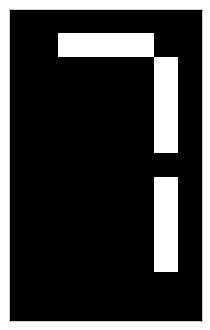

In [141]:
from matplotlib import pyplot as plt
import numpy as np

digit_7 = np.array([0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
                    0.,  0.,  1.,  1.,  1.,  1.,  0.,  0.,
                    0.,  0.,  0.,  0.,  0.,  0.,  1.,  0., 
                    0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
                    0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
                    0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  
                    0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  
                    0.,  0.,  0.,  0.,  0.,  0.,  1.,  0., 
                    0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  
                    0.,  0.,  0.,  0.,  0.,  0.,  1.,  0., 
                    0.,  0.,  0.,  0.,  0.,  0.,  1.,  0., 
                    0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
                    0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])
show_as_image(digit_7)

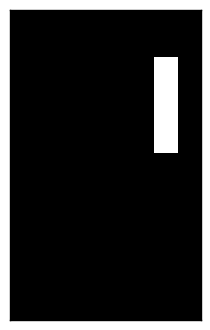

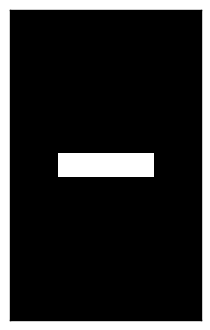

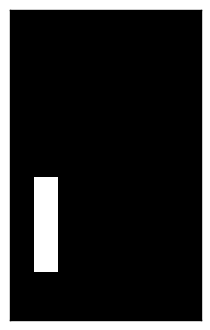

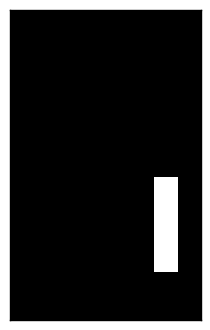

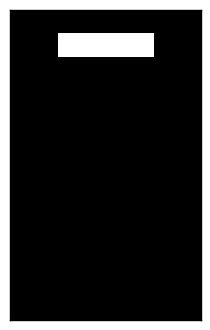

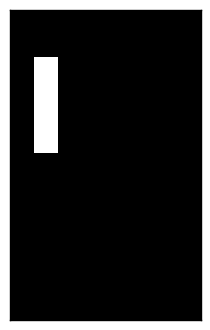

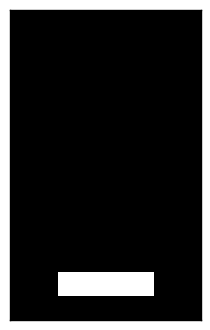

In [142]:
from sklearn.decomposition import NMF
from sklearn.datasets import load_digits

samples = np.loadtxt('data/lcd-digits.csv', delimiter=',')

model = NMF(n_components=7)

nmf_features = model.fit_transform(samples)

#through the plots we notice how NMF has expressed the digit as a sum of the components!
for component in model.components_:
    show_as_image(component)

### PCA doesn't learn parts


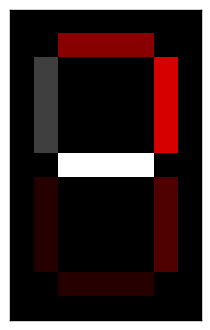

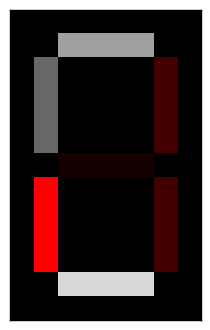

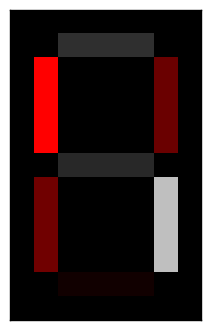

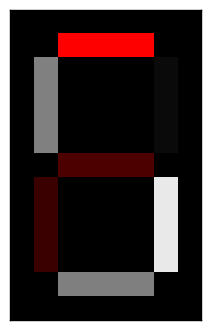

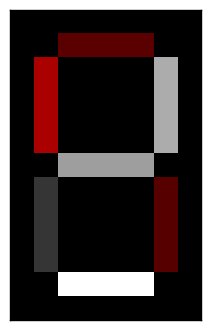

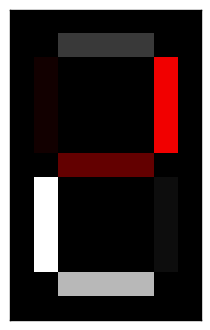

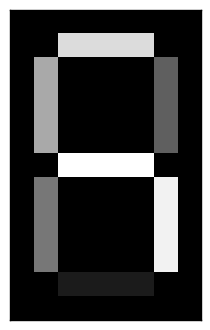

In [144]:
from sklearn.decomposition import PCA
model = PCA(n_components=7)
features = model.fit_transform(samples)
for component in model.components_:
    show_as_image(component)

## Building recommender systems using NMF
- Finding  similar artciles
- Recommend articles similar to one being read
- Strategy : apply NMF to word-frequencey array
- NMF features values describe the topics (similar artcile have similar NMF features values)

In [159]:
from sklearn.decomposition import NMF
nmf = NMF(n_components=6)

#apply NMF to word frequence array
nmf_features = nmf.fit_transform(articles)

#compare nmf features values
#using cosine similarity
from sklearn.preprocessing import normalize

norm_features = normalize(nmf_features)

current_article = norm_features[23, :]

#results in a cosine similarities
similarities = norm_features.dot(current_article)

#labling similarities

import pandas as pd
df = pd.DataFrame(norm_features, index=titles)
current_article = df.loc['Cristiano Ronaldo']

similarities = df.dot(current_article)

print(similarities.nlargest())

title
Cristiano Ronaldo     1.000000
Radamel Falcao        1.000000
Zlatan Ibrahimovi?    1.000000
Franck Ribéry         1.000000
Neymar                0.999213
dtype: float64
